# Optimal Transport

We develop a deep declarative node for solving and back-propagating through an [optimal transport (OT)](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)) problem. We make use of Sinkhorn normalization ([Cuturi, NeurIPS 2013](https://papers.nips.cc/paper/2013/hash/af21d0c97db2e27e13572cbf59eb343d-Abstract.html)) in the forward pass. For the backward pass we implement two methods, one based on unrolling the forward implementation and one based on implicit differentiation results from the [Deep Declarative Networks](https://doi.ieeecomputersociety.org/10.1109/TPAMI.2021.3059462) paper.

Let us write the entropy regularized optimal transport problem in the following form,

$$
\begin{array}{ll}
\text{minimize (over $P \in \mathbb{R}^{m \times n}_{+}$)} & \langle P, M\rangle + \frac{1}{\gamma} \text{KL}(P \| rc^T) \\
\text{subject to} & P 1 = r \\ & P^T 1 = c 
\end{array}
$$

where $r \in \mathbb{R}_{+}^m$ and $c \in \mathbb{R}_{+}^n$ with $r^T 1 = c^T 1 = 1$. Here $x = M \in \mathbb{R}^{m \times n}$ is the input to the declarative node and $y = P \in \mathbb{R}^{m \times n}_{+}$ is the output.
The above problem leads to a solution of the form

$$
P_{ij} = \alpha_i \beta_j e^{-\gamma M_{ij}}
$$

where $\alpha \in \mathbb{R}^m$ and $\beta \in \mathbb{R}^n$ are found by iteratively applying row and column normalizations.

Variants of differentiable optimal transport have been used in several prior works, including:

* [Santa Cruz et al.](https://ieeexplore.ieee.org/document/8481554), Permutation Learning, TPAMI 2018. ([code](https://github.com/rfsantacruz/deep-perm-net)).
* [Campbell et al.](https://link.springer.com/chapter/10.1007/978-3-030-58536-5_15), Solving the Blind Perspective-n-Point Problem End-To-End with Robust Differentiable Geometric Optimization, ECCV 2020. ([code](https://github.com/dylan-campbell/bpnpnet)).
* and many others.

## Forward function

The forward function performs Sinkhorn normalization until convergence (or a maximum number of iterations is reached).

In [1]:
import torch
print(torch.__version__)
torch.manual_seed(22)

import warnings
warnings.filterwarnings('ignore')

def sinkhorn(M, r=None, c=None, gamma=1.0, eps=1.0e-6, maxiters=10):
    '''Solve the entropy regularized optimal transport problem.'''
    
    m, n = M.shape
    if r is None: r = torch.ones((m, 1)) / m
    if c is None: c = torch.ones((n, 1)) / n
    assert r.shape == (m, 1) and c.shape == (n, 1)
    
    P = torch.exp(-1.0 * gamma * M)
    for i in range(maxiters):
        alpha = torch.sum(P, 1).reshape(m, 1)
        P = r / alpha * P
        
        beta = torch.sum(P, 0)
        if torch.all(torch.isclose(beta, c, atol=eps, rtol=0.0)):
            break
        P = P * c.T / beta.T
        
    return P

#
# --- testing ---
#

M = torch.log(torch.rand((3, 5), dtype=torch.float))
P = sinkhorn(M)

print(M)
print(P)

print(torch.sum(P, 1))
print(torch.sum(P, 0))

1.7.1
tensor([[-1.0054, -0.3531, -1.1701, -4.6355, -0.4190],
        [-1.6365, -0.0507, -0.3729, -0.2017, -0.2777],
        [-0.2888, -0.3748, -1.3610, -2.6995, -0.0981]])
tensor([[0.0353, 0.0458, 0.0483, 0.1550, 0.0490],
        [0.1329, 0.0678, 0.0436, 0.0037, 0.0853],
        [0.0318, 0.0864, 0.1081, 0.0413, 0.0657]])
tensor([0.3333, 0.3333, 0.3333])
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


# Back Propagating by Unrolling Sinkhorn

One way to back-propagate through optimal transport is by unrolling the Sinkhorn algorithm and applying the chain rule of differentiation to each iteration. Let's write out the calculations in the forward and backward pass:

$$
\begin{array}{rl|rl}
P_{ij}^{(0)} &= \exp(-\gamma M_{ij})
&
\frac{\partial P_{ij}^{(0)}}{\partial M_{kl}} &= \begin{cases}
    -\gamma P_{ij}^{(0)} & \text{if $ij = kl$} \\ 0 & \text{otherwise}
\end{cases}
\\
\alpha_i^{(t)} &= \sum_{j=1}^{n} P_{ij}^{(t-1)}
&
\frac{\partial \alpha_i^{(t)}}{\partial P_{kl}^{(t-1)}} &= \begin{cases}
    1 & \text{if $i = k$} \\ 0 & \text{otherwise}
\end{cases}
\\
\tilde{P}_{ij}^{(t)} &= \frac{r_i}{\alpha_i} P_{ij}^{(t-1)}
&
\frac{\partial \tilde{P}_{ij}^{(t)}}{\partial P_{kl}^{(t-1)}} &= 
\frac{\partial \tilde{P}_{ij}^{(t)}}{\partial P_{ij}^{(t-1)}} \frac{\partial P_{ij}^{(t-1)}}{\partial P_{kl}^{(t-1)}} +
\frac{\partial \tilde{P}_{ij}^{(t)}}{\partial \alpha_i} \frac{\partial \alpha_i^{(t)}}{\partial P_{kl}^{(t-1)}}
\\
& & &=
\begin{cases} \frac{r_i}{\alpha_i^{(t)}} & \text{if $ij = kl$} \\ 0 & \text{otherwise} \end{cases}
- \begin{cases} \frac{r_i P_{ij}^{(t-1)}}{\left(\alpha_i^{(t)}\right)^2} & \text{if $i = k$} \\ 0 & \text{otherwise} \end{cases}
\\
\beta_j^{(t)} &= \sum_{i=1}^{m} \tilde{P}_{ij}^{(t)}
&
\frac{\partial \beta_j^{(t)}}{\partial P_{kl}^{(t-1)}} &=
\sum_{i=1}^{m} \frac{\partial \tilde{P}_{ij}^{(t)}}{\partial P_{kl}^{(t-1)}}
\\
& & &=
\begin{cases} \frac{r_k}{\alpha_k^{(t)}} & \text{if $j = l$} \\ 0 & \text{otherwise} \end{cases}
- \frac{r_k P_{kj}^{(t-1)}}{\left(\alpha_k^{(t)}\right)^2}
\\
P_{ij}^{(t)} &= \frac{c_j}{\beta_j^{(t)}} \tilde{P}_{ij}^{(t)}
&
\frac{\partial P_{ij}^{(t)}}{\partial P_{kl}^{(t-1)}} &=
\frac{\partial P_{ij}^{(t)}}{\partial \tilde{P}_{ij}^{(t)}} \frac{\partial \tilde{P}_{ij}^{(t)}}{\partial P_{kl}^{(t-1)}} +
\frac{\partial P_{ij}^{(t)}}{\partial \beta_j} \frac{\partial \beta_j^{(t)}}{\partial P_{kl}^{(t-1)}}
\\
& & &=
\frac{c_j}{\beta_j^{(t)}} \frac{\partial \tilde{P}_{ij}^{(t)}}{\partial P_{kl}^{(t-1)}}
- \frac{{P}_{ij}^{(t-1)}}{\beta_j^{(t)}} \frac{\partial \beta_j^{(t)}}{\partial P_{kl}^{(t-1)}}
\end{array}
$$

Note that we need to store the $\alpha_i^{(t)}$ and $\beta_j^{(t)}$ in the forward pass. Then in the backward pass we can use the above equations and $\tilde{P}_{ij}^{(t)} = \frac{\beta_j}{c_j} P_{ij}^{(t)}$ and $P_{ij}^{(t-1)} = \frac{\alpha_i}{r_i} \tilde{P}_{ij}^{(t)}$ along with the incoming gradient $\frac{\partial J}{\partial P_{ij}^{(T)}}$ to compute the necessary derivatives in the chain rule to eventually arrive at $\frac{\partial J}{\partial M_{ij}}$.

**This is essentially what `torch.autograd` will do when $P$ is caculated from the `sinkhorn` function above.**


# Gradients

An alternative is to back propagate using the implicit function theorem applied to the optimality conditions. From Corollary 4.9 of [Deep Declarative Networks](https://doi.ieeecomputersociety.org/10.1109/TPAMI.2021.3059462) we have

$$
\text{D} P(M) = (H^{-1} A^T (A H^{-1} A^T)^{-1} A H^{-1} - H^{-1})B
$$

Let $f(P) = \sum_{ij} M_{ij} P_{ij} + \frac{1}{\gamma} \sum_{ij} P_{ij} \left(\log P_{ij} - \log r_i c_j\right)$ be the entropy regularized optimal transport objective. We can compute the following derivatives,

$$
\frac{\partial f}{\partial P_{ij}} = M_{ij} + \frac{1}{\gamma} \log P_{ij} + \frac{1}{\gamma} - \frac{1}{\gamma} \log r_i c_j
\\
H_{ij,kl} = \frac{\partial^2 f}{\partial P_{ij} \partial P_{kl}} = \begin{cases}
    \frac{1}{\gamma P_{ij}} & \text{if $ij = kl$} \\
    0 & \text{otherwise}
\end{cases}
\\
B_{ij,kl} = \frac{\partial^2 f}{\partial P_{ij} \partial M_{kl}} = \begin{cases}
    1 & \text{if $ij = kl$} \\
    0 & \text{otherwise}
\end{cases}
$$

Therefore $H^{-1} = \text{diag}(\gamma P_{ij})$ and $B = I_{mn \times mn}$. (Note that these are diagonal makes sense, since if not for the linear equality constraints each $P_{ij}$ would only depend on $M_{ij}$ and not any other $M_{kl}, kl \neq ij$.)

Now consider the constraints

$$
\begin{array}{ll}
\sum_{j} P_{ij} = r_i & \text{for } i = 1, \ldots, m \\
\sum_{i} P_{ij} = c_j & \text{for } j = 1, \ldots, n
\end{array}
$$

Writing this as a matrix $A$ where $P_{ij}$ has been flattened rowwise, we have

$$
A = \begin{bmatrix}
1_n^T & 0_n^T & \cdots & 0_n^T \\
0_n^T & 1_n^T & \cdots & 0_n^T \\
\vdots & \vdots & \ddots & \vdots \\
0_n^T & 0_n^T & \cdots & 1_n^T \\
I_{n \times n} & I_{n \times n} & \cdots & I_{n \times n}
\end{bmatrix} \in \mathbb{R}^{(m+n)\times mn}
$$

Note, here that $A$ has rank $m + n - 1$ (by observing that the last row is the sum of the first $m$ rows minus the next $n - 1$ rows). To apply Corollary 4.9 we therefore must remove one row (i.e., one constraint). Redefining $A$ with the first row removed, we have

$$
A = \begin{bmatrix}
0_n^T & 1_n^T & \cdots & 0_n^T \\
\vdots & \vdots & \ddots & \vdots \\
0_n^T & 0_n^T & \cdots & 1_n^T \\
I_{n \times n} & I_{n \times n} & \cdots & I_{n \times n}
\end{bmatrix} \in \mathbb{R}^{(m+n-1)\times mn}
$$

Consider the $(p,q)$-th entry of $AH^{-1}A^T$ for $p, q \in 1, \ldots, m+n-1$,

$$
(A H^{-1} A^T)_{pq} = \sum_{ij} \frac{A_{p,ij} A_{q,ij}}{H_{ij,ij}}
$$

Therefore,

$$
\begin{align*}
AH^{-1}A^T
&=
\begin{bmatrix}
\text{diag}(\sum_{j=1}^{n} H_{pj,pj}^{-1} \mid p = 2, \ldots, m)
& 
(H_{ij,ij}^{-1})_{i=2,\ldots,m \times j=1,\ldots,n} 
\\
(H_{ij,ij}^{-1})_{j=1,\ldots,n \times i=2,\ldots,m} 
&
\text{diag}(\sum_{i=1}^{m} H_{ip,ip}^{-1} \mid p = 1, \ldots, n)
\end{bmatrix}
\\
&=
\gamma \begin{bmatrix}
\text{diag}{(r_{2:m})}
&
P_{2:m,1:n}
\\
P_{2:m,1:n}^T
&
\text{diag}{(c)}
\end{bmatrix}
\end{align*}
$$

Now we can directly compute $(AH^{-1}A^T)^{-1}$ in $O((m+n-1)^3)$ time or make use of more efficient [block matrix inversion](https://en.wikipedia.org/wiki/Block_matrix) results to compute in $O((m-1)^3)$ time,

$$
\begin{bmatrix}
\Lambda_{11} & \Lambda_{12} \\ \Lambda_{21} & \Lambda_{22}
\end{bmatrix}
=
\begin{bmatrix}
\text{diag}{(r_{2:m})}
&
P_{2:m,1:n}
\\
P_{2:m,1:n}^T
&
\text{diag}{(c)}
\end{bmatrix}^{-1}
$$

where

$$
\begin{align*}
\Lambda_{11} &= (R - P_{2:m,1:n} C^{-1} P_{2:m,1:n}^T)^{-1} \\
\Lambda_{12} &= -\Lambda_{11} P_{2:m,1:n} C^{-1} \\
\Lambda_{21} &= \Lambda_{12}^T \\
\Lambda_{22} &= C^{-1} - C^{-1} P_{2:m,1:n}^T \Lambda_{12}
\end{align*}
$$

with $C = \text{diag}{(c)}$ and $R = \text{diag}{(r_{2:m})}$.

A similar derivation and corresponding algorithm for efficiently differentiating Sinkhorn was presented in [Luise et al., 2018](https://arxiv.org/abs/1805.11897).

## Backward Pass Implementation

We are now ready to compute the gradient of the loss function with respect to the input $\text{D} J(M) \in \mathbb{R}^{m \times n}$ given the gradient of the loss function with respect to the output $\text{D} J(P) \in \mathbb{R}^{m \times n}$ by multiplying from left-to-right, maintaining an $m$-by-$n$ matrix, and making the following observations,

* the $(1,1)$-block of $(AH^{-1}A^T)^{-1}$ is symmetric positive definite (so use cholesky)
* multiplication by $H^{-1}$ scales each entry by $\gamma P_{ij}$
* right-multiplication by $A^T$ concatenates summed rows and columns
* right-multiplication by $A$ distributes corresponding entries across rows and columns
* multiplication by $B$ does nothing

We have coded an efficient implementation of this in the `OptimalTransportLayer` of the `ddn.pytorch.optimal_transport` module. The code also back propagates through $r$ and $c$ if provided (and with `requires_grad` set to `True`).

# Example

We demonstrate an example of back propagating through optimal transport by finding a matrix $M$ that will result in a given doubly stochastic matrix $P_{\text{true}}$. We generate $P_{\text{true}}$ by randomly sampling a matrix $M_{\text{true}}$ and running it through the Sinkhorn algorithm. We then randomly sample a new matrix $M$ and iteratively updated it with gradient descent to minimize, $\|\text{OT}(M) - P_{\text{true}}\|^2$.

Note that since optimal transport is a many-to-one mapping the $M$ found by our optimization will not necessarily be the same as $M_{\text{true}}$. We plot the learning curve for different variants of back propagation.

We evaluate two variants of the problem, one where the model class is calibrated with the problem and one where it is mis-calibrated. For the latter we generate $P_{\text{true}}$ assuming non-uniform $r$ and $c$ but train assuming that they are uniform.

Finally, we also measure running time on different size problems.

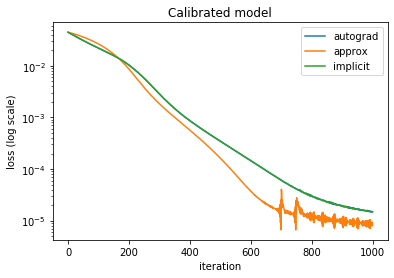

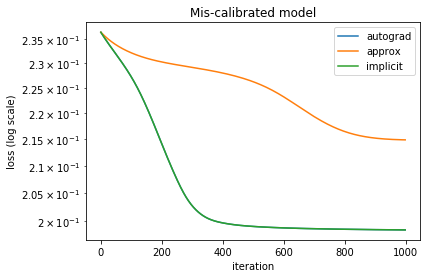

In [2]:
%matplotlib inline

import torch
import torch.optim as optim
from torch.nn.functional import normalize

torch.manual_seed(22)

import sys
sys.path.append("../")

from ddn.pytorch.optimal_transport import sinkhorn, OptimalTransportLayer

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def learnM(fcn, M_init, P_true, iters=500):
    """Find an M such that sinkhorn(M) matches P_true. Return M and the learning curve."""
    M = M_init.clone()
    M.requires_grad = True

    optimizer = optim.AdamW([M], lr=1.0e-2)

    h = []
    for i in range(iters):
        optimizer.zero_grad(set_to_none=True)
        P = fcn(M)
        J = torch.linalg.norm(P - P_true)
        h.append(J.item())
        J.backward()
        optimizer.step()

    return M, h

def plot_learning_curves(title, h1, h2, h3):
    """Plots learning curves for autograd, approx and implicit."""

    plt.figure()
    plt.semilogy(h1)
    plt.semilogy(h2)
    plt.semilogy(h3)
    plt.xlabel('iteration'); plt.ylabel('loss (log scale)')
    plt.legend(['autograd', 'approx', 'implicit'])
    plt.title(title)

# test sinkhorn, approximate gradient and implicit gradient for calibrated model

M_true = torch.randn((2, 100, 100), dtype=torch.float)
P_true = sinkhorn(M_true)

M_init = torch.log(torch.rand_like(M_true))

M1, h1 = learnM(sinkhorn, M_init, P_true, iters=1000)
M2, h2 = learnM(OptimalTransportLayer(method='approx'), M_init, P_true, iters=1000)
M3, h3 = learnM(OptimalTransportLayer(), M_init, P_true, iters=1000)

plot_learning_curves('Calibrated model', h1, h2, h3)

# test sinkhorn, approximate gradient and implicit gradient for mis-calibrated model

M_true = torch.randn((2, 100, 100), dtype=torch.float)
P_true = sinkhorn(M_true, normalize(torch.rand(1, M_true.shape[1])), normalize(torch.rand(1, M_true.shape[2])))

M_init = torch.log(torch.rand_like(M_true))

M1, h1 = learnM(sinkhorn, M_init, P_true, iters=1000)
M2, h2 = learnM(OptimalTransportLayer(method='approx'), M_init, P_true, iters=1000)
M3, h3 = learnM(OptimalTransportLayer(), M_init, P_true, iters=1000)

plot_learning_curves('Mis-calibrated model', h1, h2, h3)
plt.show()
        

Note that the *autograd* and *implicit* curves coincide since they produce the same gradients (up to numerical precision).

Running on cpu with batch size of 1...
Timing on 5-by-5 problem...
Timing on 10-by-10 problem...
Timing on 25-by-25 problem...
Timing on 50-by-50 problem...
Timing on 100-by-100 problem...
Timing on 200-by-200 problem...
Timing on 300-by-300 problem...
Timing on 500-by-500 problem...
...done
Running on cuda with batch size of 16...
Timing on 5-by-5 problem...
Timing on 10-by-10 problem...
Timing on 25-by-25 problem...
Timing on 50-by-50 problem...
Timing on 100-by-100 problem...
Timing on 200-by-200 problem...
Timing on 300-by-300 problem...
Timing on 500-by-500 problem...
...done


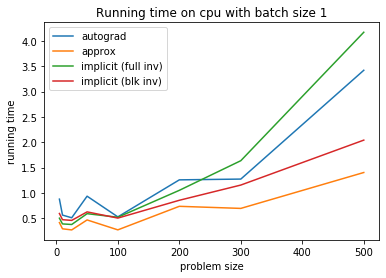

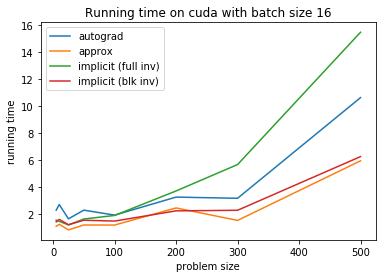

In [3]:
# running time
from timeit import timeit

def wrapper(func, *args, **kwargs):
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

def plot_running_time(batch_size, device):
    """Plot running time for given device."""
    
    torch.manual_seed(22)
    print("Running on {} with batch size of {}...".format(device, batch_size))

    n = [5, 10, 25, 50, 100, 200, 300, 500]
    t1, t2, t3, t4 = [], [], [], []
    
    for ni in n:
        print("Timing on {}-by-{} problem...".format(ni, ni))
        M_true = torch.randn((batch_size, ni, ni), dtype=torch.float)
        P_true = sinkhorn(M_true).to(device)

        M_init = torch.log(torch.rand_like(M_true)).to(device)

        t1.append(timeit(wrapper(learnM, sinkhorn, M_init, P_true), number=1))
        t3.append(timeit(wrapper(learnM, OptimalTransportLayer(method='full'), M_init, P_true), number=1))
        t2.append(timeit(wrapper(learnM, OptimalTransportLayer(method='approx'), M_init, P_true), number=1))
        t4.append(timeit(wrapper(learnM, OptimalTransportLayer(), M_init, P_true), number=1))

    print("...done")

    plt.figure()
    plt.plot(n, t1, n, t2, n, t3, n, t4)
    plt.xlabel('problem size'); plt.ylabel('running time')
    plt.legend(['autograd', 'approx', 'implicit (full inv)', 'implicit (blk inv)'])
    plt.title('Running time on {} with batch size {}'.format(device, batch_size))


plot_running_time(1, torch.device("cpu"))
if torch.cuda.is_available():
    plot_running_time(16, torch.device("cuda"))

plt.show()

Note that in addition to potential runtime advantages the implicit differentiation method (i.e., Deep Declarative Networks) also saves a significant amount of memory by not having to store intermediate Sinkhorn iterates. A GeForce RTX 2080 GPU (11GB) runs out of memory for problems above 500-by-500.

The following plots show memory usage for a single backward pass as a function of:
 1. number of sinkhorn iterations for a random problem of size 500-by-500, and
 2. problem size for a fixed number (10) of sinkhorn iterations.


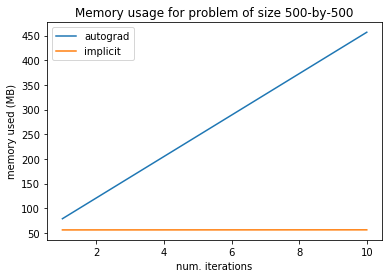

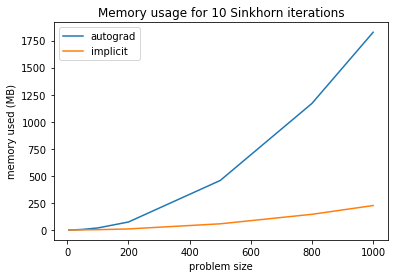

In [4]:
import torch.autograd.profiler as profiler

M_init = torch.randn((1, 500, 500), dtype=torch.float)

maxiters_range = list(range(1, 11))
probsize_range = [5, 10, 25, 50, 100, 200, 500, 800, 1000]

memory_by_maxiters = [[], []]
memory_by_probsize = [[], []]

for maxiters in maxiters_range:
    # profile autograd
    M = M_init.clone(); M.requires_grad = True
    with profiler.profile(profile_memory=True) as prof:
        P = sinkhorn(M, eps=0.0, maxiters=maxiters)
        torch.linalg.norm(P - torch.eye(M.shape[1])).backward()
    memory_by_maxiters[0].append(prof.total_average().cpu_memory_usage / (1024 * 1024))    

    # profile implicit
    M = M_init.clone(); M.requires_grad = True
    f = OptimalTransportLayer(eps=0.0, maxiters=maxiters)
    with profiler.profile(profile_memory=True) as prof:
        P = f(M)
        torch.linalg.norm(P - torch.eye(M.shape[1])).backward()
    memory_by_maxiters[1].append(prof.total_average().cpu_memory_usage / (1024 * 1024))    

for n in probsize_range:
    M_init = torch.randn((1, n, n), dtype=torch.float)

    # profile autograd
    M = M_init.clone(); M.requires_grad = True
    with profiler.profile(profile_memory=True) as prof:
        P = sinkhorn(M, eps=0.0, maxiters=10)
        torch.linalg.norm(P - torch.eye(n)).backward()
    memory_by_probsize[0].append(prof.total_average().cpu_memory_usage / (1024 * 1024))    

    # profile implicit
    M = M_init.clone(); M.requires_grad = True
    f = OptimalTransportLayer(eps=0.0, maxiters=10)
    with profiler.profile(profile_memory=True) as prof:
        P = f(M)
        torch.linalg.norm(P - torch.eye(n)).backward()
    memory_by_probsize[1].append(prof.total_average().cpu_memory_usage / (1024 * 1024))    
    

plt.figure()
plt.plot(maxiters_range, memory_by_maxiters[0])
plt.plot(maxiters_range, memory_by_maxiters[1])
plt.xlabel('num. iterations'); plt.ylabel('memory used (MB)')
plt.legend(['autograd', 'implicit'])
plt.title("Memory usage for problem of size 500-by-500")

plt.figure()
plt.plot(probsize_range, memory_by_probsize[0])
plt.plot(probsize_range, memory_by_probsize[1])
plt.xlabel('problem size'); plt.ylabel('memory used (MB)')
plt.legend(['autograd', 'implicit'])
plt.title("Memory usage for 10 Sinkhorn iterations")
plt.show()